In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import json
import os
import time
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from mstream.mstream import Mstream

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

In [4]:
DS_DIR = "data"
DS_NAMES = ["News", "News-T", "Tweets", "Tweets-T"]
DS_PATHS = [os.path.join(DS_DIR, ds_name) for ds_name in DS_NAMES]

<IPython.core.display.Javascript object>

In [5]:
def load_batches(ds_path, batch_size=int(2 ** 8)):
    with open(ds_path) as f:
        docs = []
        for line in f:
            parsed_line = json.loads(line)
            docs.append(parsed_line)
            if len(docs) == batch_size:
                yield docs
                docs = []
        if len(docs) > 0:
            yield docs

<IPython.core.display.Javascript object>

In [6]:
def transform(docs):
    return [{"id": doc["Id"], "words": doc["textCleaned"].split()} for doc in docs]

<IPython.core.display.Javascript object>

In [7]:
num_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_docs / 16)
mstream = Mstream()
y = []
times = []
for parsed_docs in load_batches(DS_PATHS[2], batch_size):
    t0 = time.process_time()
    y += mstream.process(transform(parsed_docs))
    t1 = time.process_time()
    print(t1 - t0)
    times.append(t1 - t0)

15.929090561999999
22.086805683999998
27.615999468
31.161218002
37.969757859
38.389845640000004
42.51797628099999
45.02415402699998
45.449918378999996
44.85175791700004
51.721185529000024
48.56279583999998
55.760643173999995
56.83743960600003
55.15935849300001
54.90244143799998


<IPython.core.display.Javascript object>

In [57]:
np.cumsum(np.array(times))

array([ 14.03008528,  31.03972707,  51.04131376,  72.46202304,
        97.05719657, 125.49506644, 154.86320704, 186.93606598,
       219.83331087, 254.03131453, 291.02586813, 329.40445724,
       365.373442  , 404.90888313, 449.51232855, 490.9583228 ,
       532.6385391 ])

<IPython.core.display.Javascript object>

In [24]:
m.sum(axis=1)

array([ 86.04950894, 122.47312375, 151.58861346,  82.97390427,
        54.00655597,  88.64908107, 104.47145259, 157.22200212,
        60.59958485,  73.07717064, 106.63670419, 111.39617205,
        69.28448717,  92.81293938, 135.42683546,  87.13489973,
        80.18629882,  83.56045601,  97.60789163,  79.31832097,
        63.49706788,  69.85645844,  88.72059895,  76.1727235 ,
       145.01856781,  90.27081206, 126.10633156,  77.43335623,
        78.43306705, 155.02202458, 167.63783152, 134.58608627,
        86.08858616,  97.50883287,  95.841065  , 122.31085835,
       137.60857858,  83.8564083 ,  73.2034007 ,  98.72056008,
        86.38420785,  67.89235065,  75.51518086, 101.48272312,
        64.45342823,  99.08437136, 143.9118371 ,  47.53140598,
        61.16574253,  92.5500249 ,  47.07259653, 121.05689779,
        70.90251689, 210.73134732,  67.23999253, 107.91739689,
        41.17069   , 148.30172888,  97.85640075,  63.23681966,
        91.32493575,  70.02746609,  44.41616715,  63.28

<IPython.core.display.Javascript object>

In [8]:
m = mstream.topic_term_pmf()
m

array([[0.00360298, 0.00672861, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04676268, 0.        , 0.01674513, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<IPython.core.display.Javascript object>

Caculate the NMI for each batch

Calculate the NMI as a function of the number of iterations

In [92]:
num_batches = 16
max_num_iter = 11
num_iters = list(range(1, max_num_iter))
ds_nmis = []
for ds_path in [DS_PATHS[2]]:
    num_total_docs = sum([len(batch) for batch in load_batches(ds_path)])
    batch_size = math.ceil(num_total_docs / num_batches)
    nmis = []
    for num_iter in num_iters:
        mstream = Mstream(num_iter)
        y_hat = []
        y = []
        for parsed_docs in load_batches(ds_path, batch_size):
            y += [doc["clusterNo"] for doc in parsed_docs]
            y_hat += mstream.process(transform(parsed_docs))
        nmi = normalized_mutual_info_score(y, y_hat)
        nmis.append(nmi)
    ds_nmis.append(nmis)

<IPython.core.display.Javascript object>

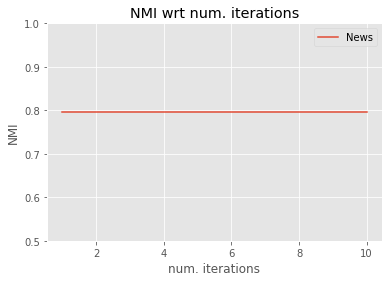

<IPython.core.display.Javascript object>

In [93]:
fig, ax = plt.subplots()
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
# ax.set_yticks(np.arange(0.5, 1.1, step=0.1))
ax.set_ylim(0.5, 1)
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()